In [1]:
import gym
import numpy as np
#from gym import spaces
#from gym.utils import seeding


class DiceGame(gym.Env):

    def __init__(self):
        self.state = np.zeros((7,3))
        self.top = [1000,6,6,6,6,6,6] #Arb top for Col 0, High so it doesn't Accidentally Trigger Col Done Count
        self.dice = (np.random.randint(1, 7),np.random.randint(1, 7),np.random.randint(1, 7))
        self.state[0] = self.dice
        self.blackDots = 2
        self.turn = 0 #Total Turns, or how many times opponent had a chance to counter attack
        self.round = 0 #Rounds within a current turn, used to track reward
        self.reward = 0
        self.bust = False
        self.done = False
        
    def step(self, action):
        if self.done:
            return self.state, self.dice, self.blackDots, self.turn, 0, self.done
        else:
            #assert self.action_space.contains(action)
            assert action in [0,1,2,3,4,5]
            # 0 is dice 1 and stay
            # 1 is dice 1 and go
            # 2 is dice 2 and stay
            # 3 is dice 2 and go
            # 4 is dice 3 and stay
            # 5 is dice 3 and go
            dicePick = self.dice[action//2] #Numerical Value of Dice Picked
            stay = (action%2 == 0) #Stay or push value

            #Code for checking if move is legal because top has been reached previously
            #in either Black or Colors
            if any (X >= self.top[dicePick] for X in env.state[dicePick]):
                self.bust=True

            #Code for checking if move is illegal due to out of black dots and attempting to place another
            if env.state[dicePick][2]==0 and self.blackDots<=0:
                self.bust=True

            #Bust, Reset all Black Dots to 0 and increase Turn. Reset and set what is needed for next round
            if self.bust:
                for i in range(len(env.state)):
                    env.state[i,2]=0
                self.turn+=1
                self.blackDots=2
                self.bust=False
                self.reward=(-1)*self.round
                self.round=0
                self.dice = (np.random.randint(1, 7),np.random.randint(1, 7),np.random.randint(1, 7))
                self.state[0] = self.dice

            #Increase picked value. Decrease BlackDot count if needed
            else:
                #If new blackdot Placement, initialize blackdot
                if self.state[dicePick][2]==0:
                    self.state[dicePick][2]=self.state[dicePick][0]
                    self.blackDots-=1            
                self.state[dicePick][2]+=1
                self.round+=1
                self.reward=0
                self.dice = (np.random.randint(1, 7),np.random.randint(1, 7),np.random.randint(1, 7))
                self.state[0] = self.dice

                #If stay also chosen, increase turn count, lock in and reset blackDots, reset BD count
                if stay:
                    for i in range(1,7):
                        if env.state[i][2]>0:
                            env.state[i][0]=env.state[i][2] 
                            env.state[i][2]=0
                    self.turn+=1
                    self.blackDots=2
                    self.bust=False
                    self.reward=(self.round-1)
                    self.round=0
                    
                    countDone=0
                    for i in range(1,7):
                        if env.state[i][0]>=self.top[i]:
                            countDone+=1
                    if (countDone>=3):
                        self.done = True
                        self.reward = 1000#/self.turn #Arb Reward for completing Game
                

            return self.state, self.dice, self.blackDots, self.turn, self.reward, self.done
        
    def softreset(self):
        self.turn+=1
        self.blackDots=2
        self.bust=False
        self.round=0

    def reset(self):
        self.state = np.zeros((7,3))
        self.top = [1000,6,6,6,6,6,6]
        self.dice = (np.random.randint(1, 7),np.random.randint(1, 7),np.random.randint(1, 7))
        self.state[0] = self.dice
        self.blackDots = 2
        self.turn = 0
        self.round = 0
        self.reward = 0
        self.bust = False
        self.done = False
        return self.state, self.dice, self.blackDots, self.turn, self.reward, self.done

In [59]:
env= DiceGame()
env.state

array([[6., 6., 3.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, InputLayer
from tensorflow.keras.optimizers import Adam

In [61]:
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [9]:
def  NNInput(envState):
  return envState.reshape(1,21)

In [63]:
env=DiceGame()
model.predict(NNInput(env.state))

array([[0.2550364 , 0.12296843, 0.20460694, 0.13324167, 0.17646262,
        0.10768393]], dtype=float32)

In [64]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               5632      
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 1542      
Total params: 270,086
Trainable params: 270,086
Non-trainable params: 0
_________________________________________________________________


In [65]:
env.state, env.dice, env.state.shape

(array([[4., 4., 5.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), (4, 4, 5), (7, 3))

In [66]:
env.reset()

(array([[4., 3., 6.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]), (4, 3, 6), 2, 0, 0, False)

In [67]:
env.state

array([[4., 3., 6.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [68]:
#model.predict(NNInput(s))

In [69]:
# env.reset()
# s = env.state

In [ ]:
discountFactor = 0.95
explore = 0.5
decay = 0.5
num_eps = 2000
turn_list=[]
env = DiceGame()
for i in range(num_eps):
  env.reset()
  #explore *= decay
  explore = 1 - i/num_eps
  print("Episode {} of {}".format(i+1, num_eps))
  done= False
  while not done:

    s = env.state  

    if np.random.random() < explore:
      action = np.random.randint(0, 6)
    else:
      action = np.argmax(model.predict(NNInput(s)))    

    newS,_,_,_,reward, done = env.step(action)
    futureReward = reward + discountFactor * np.max(model.predict(NNInput(newS)))
    target_vec= model.predict(NNInput(s))[0]
    target_vec[action] = futureReward

    model.fit(NNInput(s), target_vec.reshape(1,6), verbose=0)
  turn_list.append(env.turn)


In [7]:
a=np.random.rand(1,6)
print(a)

[[0.76671315 0.18274665 0.62561513 0.36950157 0.91004216 0.91100529]]


In [8]:
a.argmax()

5

In [4]:
turn_list

NameError: ignored

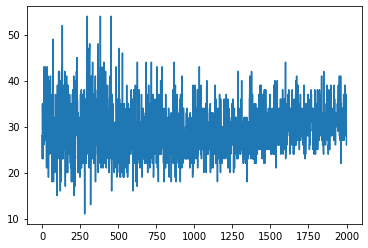

In [72]:
import seaborn
seaborn.lineplot(x=range(len(turn_list)), y=turn_list)

In [73]:
model.save('/content/drive/MyDrive/Colab Notebooks/model')


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/model/assets


In [74]:
from tensorflow import keras
model2 = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/model')


In [75]:
model.predict(NNInput(s))

array([[1., 0., 0., 0., 0., 0.]], dtype=float32)

In [76]:
model2.predict(NNInput(s))

array([[1., 0., 0., 0., 0., 0.]], dtype=float32)